## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ssl  # Needed for SSL fix
from bs4 import BeautifulSoup 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, 
                             roc_auc_score, roc_curve, precision_recall_fscore_support)
from imblearn.over_sampling import SMOTE

### FIX: SSL and NLTK Downloads
### This block fixes the 'LookupError' and connection issues

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

print("Downloading NLTK resources...")
nltk.download('punkt')
nltk.download('punkt_tab')  # Required for newer NLTK versions
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("Setup completed successfully.")

Setup completed successfully.


[nltk_data] Downloading package punkt to /home/mdvr0480/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mdvr0480/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mdvr0480/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mdvr0480/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mdvr0480/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Set plot style

In [3]:
sns.set(style='whitegrid')
print("Libraries imported successfully.")

Libraries imported successfully.


## 2: Load Data and Basic EDA

In [4]:
try:
    df = pd.read_csv('DataSet.csv')
    print("Dataset loaded. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'DataSet.csv' not found. Please upload the file.")

Dataset loaded. Shape: (17880, 18)


### FIX: Convert Target Label from 't'/'f' to 1/0
### This prevents the 'ValueError: pos_label' error later

In [5]:
if df['fraudulent'].dtype == 'object':
    print("Converting 't'/'f' labels to 1/0...")
    df['fraudulent'] = df['fraudulent'].map({'t': 1, 'f': 0})

Converting 't'/'f' labels to 1/0...


### Check for missing values

In [6]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
dtype: int64


## Target Variable Distribution

In [7]:
class_counts = df['fraudulent'].value_counts()
print("\nClass Distribution (0: Real, 1: Fraud):\n", class_counts)


Class Distribution (0: Real, 1: Fraud):
 fraudulent
0    17014
1      866
Name: count, dtype: int64


## Visualize Imbalance

/tmp/ipykernel_17339/2393650704.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=df, palette='coolwarm')


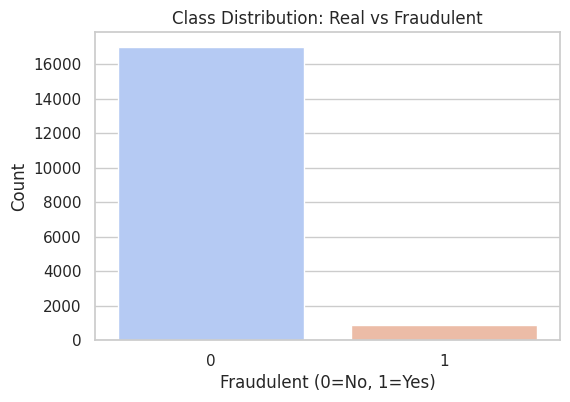

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df, palette='coolwarm')
plt.title('Class Distribution: Real vs Fraudulent')
plt.xlabel('Fraudulent (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

### Calculate Ratio

In [9]:
if 1 in class_counts and 0 in class_counts:
    ratio = class_counts[1] / class_counts[0]
    print(f"\nFraud to Real Ratio: {ratio:.4f}")
    print(f"Percentage of Fraud: {class_counts[1] / len(df) * 100:.2f}%")


Fraud to Real Ratio: 0.0509
Percentage of Fraud: 4.84%


## 3: Advanced Text Preprocessing
### Initialize tools

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_cleaning(text):
    """
    Cleans text by removing HTML, replacing specific patterns (Email, URL, Money),
    and applying lemmatization.
    """
    if not isinstance(text, str):
        return ""
        
    # 1. Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ") 
    
    # 2. Feature Engineering: Replace patterns with tokens
    # This helps the model identify fraud patterns (e.g., asking for money or private emails)
    text = re.sub(r'http\S+|www\.\S+', ' _URL_ ', text)
    text = re.sub(r'\S+@\S+', ' _EMAIL_ ', text)
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', ' _PHONE_ ', text)
    text = re.sub(r'[\$€£]\d+|\d+[\$€£]', ' _MONEY_ ', text)
    
    # 3. Remove non-letters (keep underscores for tokens)
    text = re.sub(r'[^a-zA-Z_]', ' ', text).lower()
    
    # 4. Tokenize & Lemmatize
    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2
    ]
    
    return ' '.join(cleaned_tokens)

### Combine important text columns

In [11]:
print("Combining text columns...")
df.fillna('', inplace=True)
df['text_combined'] = (df['title'] + ' ' + df['company_profile'] + ' ' + 
                       df['description'] + ' ' + df['requirements'])

Combining text columns...


### Apply cleaning

In [12]:
print("Applying advanced preprocessing (this may take a minute)...")
df['cleaned_text'] = df['text_combined'].apply(advanced_cleaning)
print("Preprocessing completed.")

Applying advanced preprocessing (this may take a minute)...
Preprocessing completed.


## 4: Vectorization

### Using TF-IDF with Unigrams and Bigrams

In [13]:
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit features to prevent memory issues
    ngram_range=(1, 2), # Use single words and pairs of words
    min_df=5,           # Ignore very rare words
    max_df=0.95         # Ignore very common words
)

print("Vectorizing text...")
X = tfidf.fit_transform(df['cleaned_text'])
y = df['fraudulent'] # This is now definitely 0 and 1

print("Feature Matrix Shape:", X.shape)

Vectorizing text...
Feature Matrix Shape: (17880, 5000)


## 5: Train-Test Split & SMOTE
### Split data (Stratified to maintain class ratio)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (12516, 5000), Test shape: (5364, 5000)


### Apply SMOTE to training data only

In [15]:
print("Applying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Train Class Distribution:\n", y_train.value_counts())
print("Resampled Train Class Distribution:\n", y_train_resampled.value_counts())

Applying SMOTE to handle class imbalance...
Original Train Class Distribution:
 fraudulent
0    11910
1      606
Name: count, dtype: int64
Resampled Train Class Distribution:
 fraudulent
0    11910
1    11910
Name: count, dtype: int64


## 6: Model Training

### 1. SVM Classifier

In [16]:
print("Training SVM (Linear Kernel)...")
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test)
print("SVM Trained.")

Training SVM (Linear Kernel)...
SVM Trained.


### 2. KNN Classifier

In [17]:
print("Training KNN (k=5, distance weights)...")
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test)
print("KNN Trained.")

Training KNN (k=5, distance weights)...
KNN Trained.


## 7: Evaluation Metrics


=== Evaluation for SVM ===


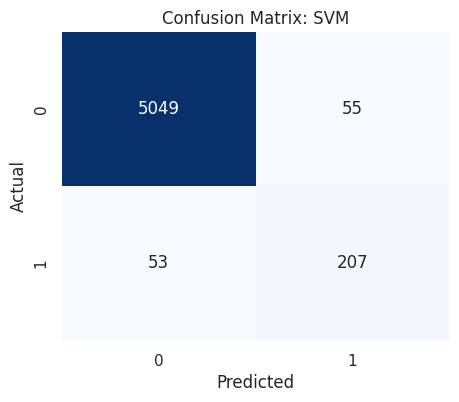

Accuracy:  0.9799
Precision: 0.7901
Recall:    0.7962 (Sensitivity)
F1-Score:  0.7931
False Negatives (Missed Fraud): 53
------------------------------

=== Evaluation for KNN ===


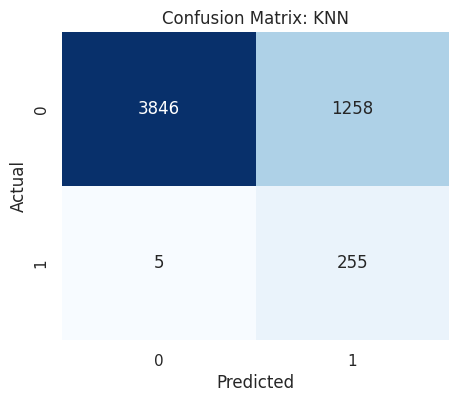

Accuracy:  0.7645
Precision: 0.1685
Recall:    0.9808 (Sensitivity)
F1-Score:  0.2876
False Negatives (Missed Fraud): 5
------------------------------


In [18]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== Evaluation for {model_name} ===")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Plotting CM
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Metrics (pos_label is now implicitly 1)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f} (Sensitivity)")
    print(f"F1-Score:  {f1:.4f}")
    print(f"False Negatives (Missed Fraud): {fn}")
    print("-" * 30)

evaluate_model(y_test, y_pred_svm, "SVM")
evaluate_model(y_test, y_pred_knn, "KNN")

## 8: ROC-AUC Curve

### Get probabilities

In [19]:
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

### Calculate AUC

In [20]:
auc_svm = roc_auc_score(y_test, y_prob_svm)
auc_knn = roc_auc_score(y_test, y_prob_knn)

### Plot ROC

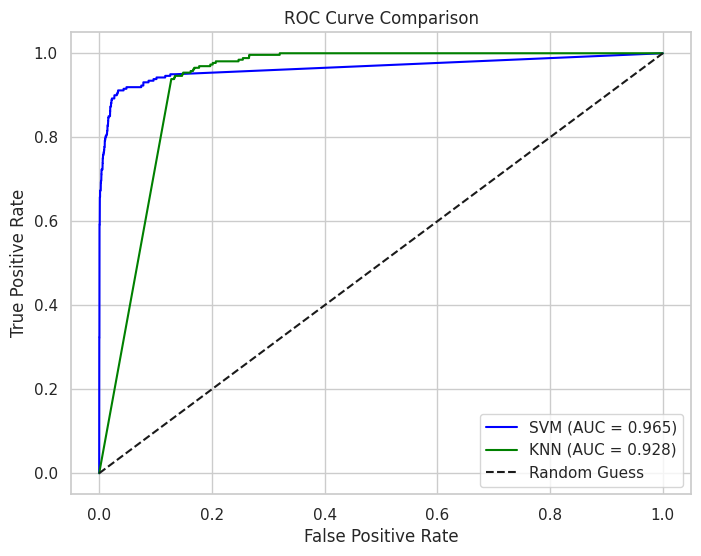

SVM AUC: 0.9652
KNN AUC: 0.9277


In [21]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})', color='blue')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

print(f"SVM AUC: {auc_svm:.4f}")
print(f"KNN AUC: {auc_knn:.4f}")